In [ ]:
from fastai.vision.all import *
import kornia

In [ ]:
#export
def get_aug_pipe(size, min_scale=0.2, max_scale=1., stats=imagenet_stats, s=.6,
                 color=True, xtra_tfms=[]):
    "SimCLR augmentations"
    tfms = []
    tfms += [kornia.augmentation.RandomResizedCrop((size, size),
                                                   scale=(min_scale, max_scale),
                                                   ratio=(3/4, 4/3))]
    tfms += [kornia.augmentation.RandomHorizontalFlip()]
    
    if color: tfms += [kornia.augmentation.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)]
    if color: tfms += [kornia.augmentation.RandomGrayscale(p=0.2)]    
    if stats is not None: tfms += [Normalize.from_stats(*stats)]
    
    tfms += xtra_tfms
    
    pipe = Pipeline(tfms)
    pipe.split_idx = 0
    return pipe

In [ ]:
#export
def create_encoder(arch, n_in=3, pretrained=True, cut=None, concat_pool=True):
    "Create encoder from a given arch backbone"
    encoder = create_body(arch, n_in, pretrained, cut)
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    return nn.Sequential(*encoder, pool, Flatten())

In [ ]:
#export
class MLP(Module):
    "MLP module as described in paper"
    def __init__(self, dim, projection_size=256, hidden_size=2048):
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, projection_size)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
#export
class SwAVModel(Module):
    def __init__(self,encoder,projector,prototypes): 
        self.encoder,self.projector,self.prototypes = encoder,projector,prototypes
    
    def forward(self, inputs): 
        
        if not isinstance(inputs, list): inputs = [inputs]
            
        crop_idxs = torch.cumsum(torch.unique_consecutive(
                                torch.tensor([inp.shape[-1] for inp in inputs]),
                                return_counts=True)[1], 0)

        start_idx = 0
        for idx in crop_idxs:
            _z = self.encoder(torch.cat(inputs[start_idx: idx]))
            if not start_idx: z = _z
            else:             z = torch.cat((z, _z))
            start_idx = idx
        
        z = F.normalize(self.projector(z))
        return z, self.prototypes(z)

In [ ]:
#export
def create_swav_model(arch=resnet50, n_in=3, pretrained=True, cut=None, concat_pool=True,
                      hidden_size=256, projection_size=128, n_protos=3000):
    "Create SwAV from a given arch"
    encoder = create_encoder(arch, n_in, pretrained, cut, concat_pool)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = MLP(representation.size(1), projection_size, hidden_size=hidden_size)  
    prototypes = nn.Linear(projection_size, n_protos, bias=False)
    apply_init(projector)
    with torch.no_grad():
        w = prototypes.weight.data.clone()
        prototypes.weight.copy_(F.normalize(w))
    return SwAVModel(encoder, projector, prototypes)

In [ ]:
#export
def sinkhorn_knopp(Q, nmb_iters, device=default_device):
    "https://en.wikipedia.org/wiki/Sinkhorn%27s_theorem#Sinkhorn-Knopp_algorithm"
    with torch.no_grad():
        sum_Q = torch.sum(Q)
        Q /= sum_Q

        r = (torch.ones(Q.shape[0]) / Q.shape[0]).to(device)
        c = (torch.ones(Q.shape[1]) / Q.shape[1]).to(device)

        curr_sum = torch.sum(Q, dim=1)

        for it in range(nmb_iters):
            u = curr_sum
            Q *= (r / u).unsqueeze(1)
            Q *= (c / torch.sum(Q, dim=0)).unsqueeze(0)
            curr_sum = torch.sum(Q, dim=1)
        return (Q / torch.sum(Q, dim=0, keepdim=True)).t().float()

In [ ]:
class SWAVLoss(Module):
    def __init__(self): pass     
    def forward(self,log_ps,qs):
        "Multi crop loss"
        loss = 0
        for i in range(len(qs)):
            l = 0
            q = qs[i]
            for p in (log_ps[:i] + log_ps[i+1:]):
                l -= torch.mean(torch.sum(q*p, dim=1))/(len(log_ps)-1)
            loss += l/len(qs)
        return loss

In [ ]:
#export
class SWAV(Callback):
    def __init__(self, crop_sizes=[224,96], 
                       num_crops=[2,6],
                       min_scales=[0.25,0.05],
                       max_scales=[1.,0.14],
                       crop_assgn_ids=[0,1],
                       eps=0.05,
                       n_sinkh_iter=3,
                       temp=0.1,
                 **aug_kwargs):
        
        store_attr('num_crops,crop_assgn_ids,temp,eps,n_sinkh_iter')
        self.augs = []
        for nc, size, mins, maxs in zip(num_crops, crop_sizes, min_scales, max_scales):
            self.augs += [get_aug_pipe(size, mins, maxs, **aug_kwargs) for i in range(nc)]
                
    
    def before_batch(self):
        "Compute multi crop inputs"
        self.bs = self.x.size(0)
        self.learn.xb = ([aug(self.x) for aug in self.augs],)
        

    def after_pred(self):
        "Compute ps and qs"    
        embedding, output = self.pred
        with torch.no_grad():
            qs = []
            for i in self.crop_assgn_ids:
                # TODO: Store previous batch embeddings
                # to be used in Q calculation
                # Store approx num_proto//bs batches 
                # output.size(1)//self.bs
                target_b = output[self.bs*i:self.bs*(i+1)]
                q = torch.exp(target_b/self.eps).t()
                q = sinkhorn_knopp(q, self.n_sinkh_iter, q.device)
                qs.append(q)
        
        log_ps = []
        for v in np.arange(np.sum(self.num_crops)):
            log_p = F.log_softmax(output[self.bs*v:self.bs*(v+1)] / self.temp, dim=1)
            log_ps.append(log_p)
                           
        self.learn.pred, self.learn.yb = log_ps, (qs,)
    
    
    def after_batch(self):
        with torch.no_grad():
            w = learn.model.prototypes.weight.data.clone()
            learn.model.prototypes.weight.data.copy_(F.normalize(w))
        
        
    def show_one(self):
        xb = self.learn.xb[0]
        i = np.random.choice(self.bs)
        images = [aug.normalize.decode(b.to('cpu').clone()).clamp(0.1)[i] 
                      for b, aug in zip(xb, self.augs)]
        show_images(images)

## Pretext Training

In [ ]:
sqrmom=0.99
mom=0.95
beta=0.
eps=1e-4
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [ ]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    files = get_image_files(source)
    tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=0.9)], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [ ]:
bs=64
resize, size = 160, 128

In [ ]:
dls = get_dls(resize, bs)
model = create_swav_model(arch=xresnet34, n_in=3, pretrained=False)
learn = Learner(dls, model, SWAVLoss(),
                cbs=[SWAV(crop_sizes=[size,96], 
                          num_crops=[2,6],
                          min_scales=[0.25,0.2],
                          max_scales=[1.0,0.35]),
                     TerminateOnNaNCallback()])

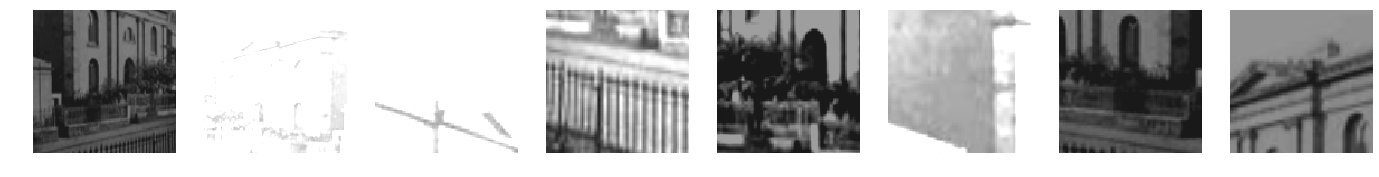

In [ ]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.swav.show_one()

In [ ]:
# learn.to_fp16();

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.0020892962347716093)

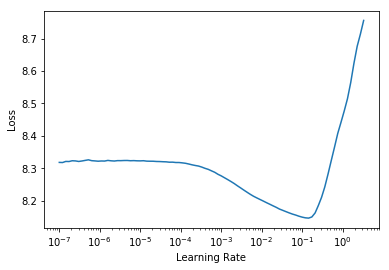

In [ ]:
learn.lr_find()

In [ ]:
lr=1e-2
wd=1e-2
epochs=100

In [ ]:
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, wd=wd, pct_start=0.5)

epoch,train_loss,valid_loss,time
0,7.993817,7.985536,03:53
1,7.987371,7.981415,03:55
2,7.979490,7.972656,03:55
3,7.975750,7.965088,03:55
4,7.937461,7.931849,03:55
5,7.932747,7.935186,03:55
6,7.918273,7.923591,03:55
7,7.905535,7.908861,03:55
8,7.859147,7.858273,03:56
9,7.781117,7.825843,03:56


In [ ]:
save_name = f'swav_iwang_sz{size}_epc100'

In [ ]:
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')

In [ ]:
learn.recorder.losses

[]

## Downstream Task

In [ ]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    files = get_image_files(source, folders=['train', 'val'])
    splits = GrandparentSplitter(valid_name='val')(files)
    
    item_aug = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    tfms = [[PILImage.create, ToTensor, *item_aug], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=splits)
    
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [ ]:
def do_train(epochs=5, runs=5, size=size, bs=bs, lr=lr, save_name=None):
    dls = get_dls(size, bs)
    for run in range(runs):
        print(f'Run: {run}')
        learn = cnn_learner(dls, xresnet34, opt_func=opt_func, normalize=False,
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy(),
                pretrained=False)

        if save_name is not None:
            state_dict = torch.load(learn.path/learn.model_dir/f'{save_name}_encoder.pth')
            learn.model[0].load_state_dict(state_dict)
            print("Model loaded...")
            
        learn.unfreeze()
        learn.fit_flat_cos(epochs, lr, wd=wd)

### 5 epochs

In [ ]:
lr = 1e-2
epochs = 5
runs = 5

In [ ]:
do_train(epochs, runs, lr=lr, save_name=save_name)

Run: 0
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.173769,1.954930,0.473148,0.866887,00:22
1,1.029763,1.831063,0.523797,0.878850,00:22
2,0.969776,1.816909,0.558666,0.869687,00:22
3,0.915550,1.743909,0.584373,0.907101,00:22
4,0.829070,1.546164,0.647238,0.922627,00:22


Run: 1
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.156928,2.031741,0.435989,0.861033,00:22
1,1.027517,1.939481,0.482311,0.884958,00:22
2,0.977137,1.751871,0.547722,0.893866,00:23
3,0.921234,1.708871,0.589972,0.890048,00:22
4,0.843251,1.545160,0.645711,0.924408,00:22


Run: 2
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.175344,1.872386,0.511581,0.882922,00:21
1,1.043144,1.763668,0.555103,0.900993,00:21
2,0.963885,1.912734,0.497073,0.874523,00:21
3,0.941352,1.693227,0.587427,0.913719,00:21
4,0.824273,1.570005,0.635022,0.918045,00:22


Run: 3
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.163305,2.001638,0.462204,0.857470,00:21
1,1.030824,1.922594,0.509544,0.886231,00:21
2,0.971310,1.814036,0.545686,0.877322,00:21
3,0.934993,1.692231,0.586663,0.910919,00:21
4,0.836493,1.601694,0.614915,0.916009,00:21


Run: 4
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.173550,1.968474,0.475439,0.873250,00:21
1,1.032172,1.851037,0.523797,0.876304,00:21
2,0.963610,1.805294,0.536269,0.892339,00:21
3,0.914703,1.849431,0.556885,0.897175,00:21
4,0.826285,1.571437,0.628150,0.923390,00:21


In [ ]:
np.mean([0.647238, 0.645711, 0.635022, 0.614915, 0.628150])

0.6342072

### 20 epochs

In [ ]:
epochs = 20
runs = 3

In [ ]:
do_train(epochs, runs, save_name=save_name)

Run: 0
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.172397,2.023369,0.452787,0.872232,00:21
1,1.048891,1.816604,0.524561,0.906083,00:21
2,0.982772,1.840554,0.552812,0.902265,00:21
3,0.905956,1.855358,0.548231,0.883431,00:21
4,0.879575,1.803466,0.555612,0.898702,00:21
5,0.857640,1.705957,0.597353,0.899466,00:21
6,0.838035,1.681782,0.594299,0.911173,00:22
7,0.824282,1.604416,0.607534,0.923899,00:21
8,0.801727,1.749159,0.600662,0.906592,00:21
9,0.777467,1.545955,0.655638,0.930262,00:21


Run: 1
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.166445,1.948399,0.470858,0.884194,00:21
1,1.032198,2.034898,0.456605,0.864342,00:21
2,0.980184,1.837205,0.547468,0.864851,00:21
3,0.934421,1.787043,0.564266,0.889794,00:21
4,0.896315,1.702195,0.596844,0.912191,00:21
5,0.865639,1.659661,0.602952,0.915500,00:21
6,0.831547,1.766076,0.579028,0.912446,00:21
7,0.808244,1.724547,0.601680,0.900229,00:21
8,0.810060,1.721077,0.604225,0.908883,00:21
9,0.791233,1.636717,0.639348,0.912446,00:21


Run: 2
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.169256,1.922205,0.477984,0.872232,00:21
1,1.037950,1.914560,0.487910,0.882158,00:21
2,0.969144,1.759319,0.567320,0.889285,00:21
3,0.925919,1.835557,0.551031,0.897429,00:21
4,0.874961,1.815813,0.590227,0.903792,00:21
5,0.851673,1.687898,0.593281,0.910919,00:21
6,0.831319,1.663185,0.615424,0.916773,00:21
7,0.821747,1.681809,0.604734,0.909137,00:21
8,0.798910,1.709096,0.607534,0.915755,00:21
9,0.797166,1.622134,0.619242,0.922372,00:21


In [ ]:
np.mean([0.674472, 0.658692, 0.680326])

0.6711633333333333

### 80 epochs

In [ ]:
epochs = 80
runs = 1

In [ ]:
do_train(epochs, runs, save_name=save_name)

Run: 0
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.184580,1.934737,0.472894,0.883431,00:21
1,1.041719,1.815343,0.535505,0.894375,00:21
2,0.969628,1.711633,0.578264,0.905828,00:21
3,0.914409,1.691567,0.588954,0.903792,00:21
4,0.877764,1.736985,0.592517,0.914991,00:21
5,0.867082,1.731112,0.594553,0.898956,00:21
6,0.841451,1.645919,0.622805,0.917791,00:21
7,0.821224,1.626836,0.632985,0.918809,00:21
8,0.804854,1.711660,0.595571,0.900993,00:21
9,0.798585,1.588638,0.639094,0.913719,00:21


### 200 epochs

In [ ]:
epochs = 200
runs = 1

In [ ]:
do_train(epochs, runs, save_name=save_name)

Run: 0
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.159623,1.955200,0.479002,0.875541,00:21
1,1.044386,1.850894,0.506745,0.887758,00:21
2,0.977252,1.789244,0.539323,0.893612,00:21
3,0.934943,1.879216,0.529142,0.903538,00:21
4,0.884970,1.769760,0.559684,0.896411,00:21
5,0.867082,1.705800,0.603716,0.906592,00:21
6,0.834456,1.719087,0.588190,0.902265,00:21
7,0.816135,1.782088,0.587681,0.884194,00:21
8,0.807418,1.626077,0.635531,0.915755,00:21
9,0.790614,1.705302,0.607025,0.901756,00:21
